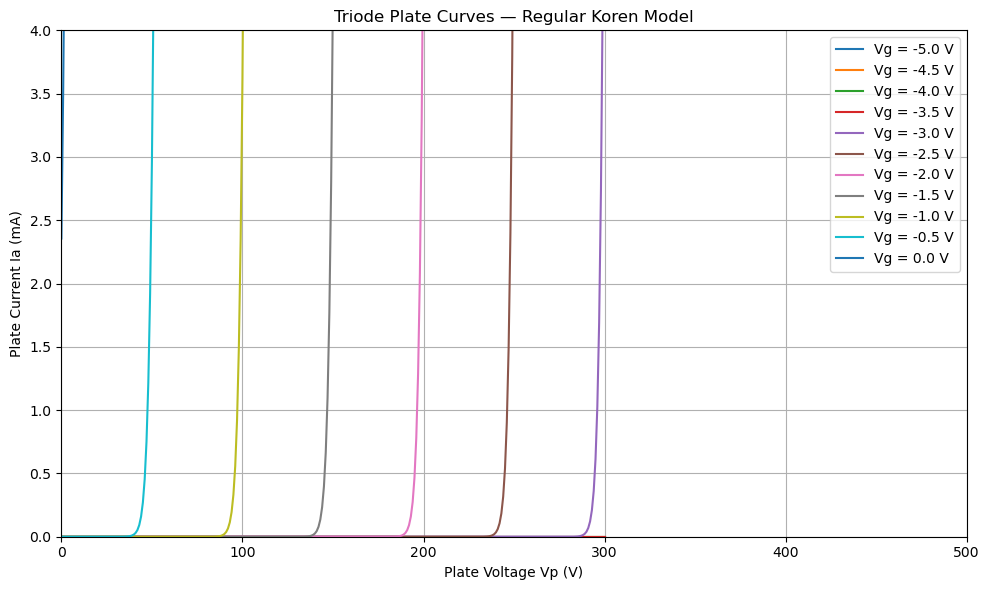

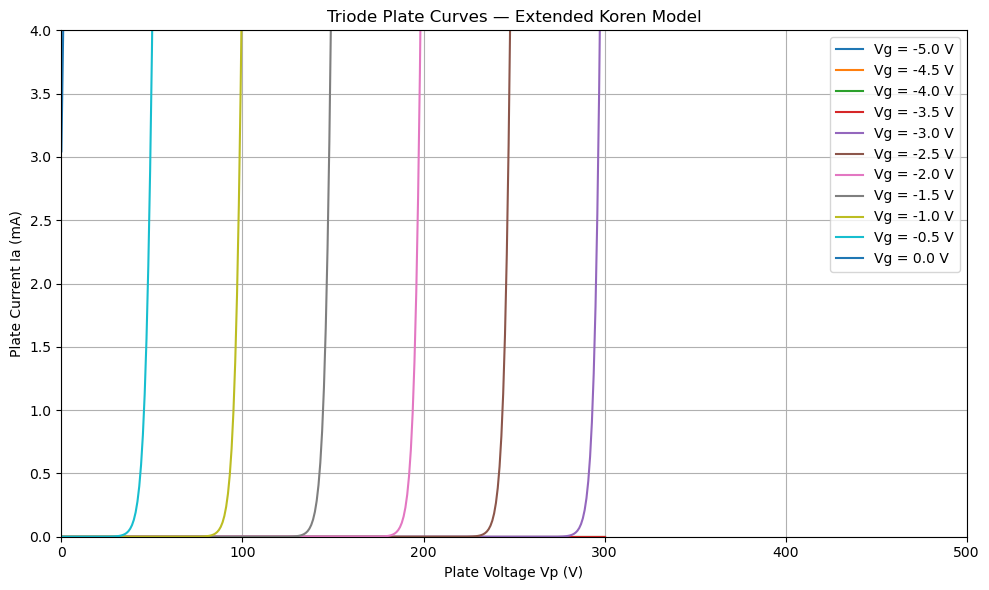

In [1]:
import matplotlib.pyplot as plt
import numpy as np

class Triode:
    def __init__(self, Vp, Vg_list, mu, kp, kg, kv, gamma = None):
        self.Ip = []
        for Vg in Vg_list:
            if not gamma:
                # Regular Koren Model
                E1 = np.log(1 + np.exp(mu * (Vg + Vp / mu) / (2 * kv)))
                self.Ip.append(((Vp + kp)**1.5 / kg) * E1**2)
            else:
                # Extended Koren Model
                P = (Vp + kp) ** 1.5
                U = mu / (2 * kv) * (Vg + Vp / mu)
                ln_term = np.log1p(np.exp(U))  # log(1 + exp(U))
                self.Ip.append((P / kg) * (ln_term ** gamma))

# Tube model parameters
mu = 100 # Amplification factor
kp = 300 # Plate voltage shaping constant
kg = 1060 # Perveance scaling factor
kv = 1.73 # Exponential shaping constant

# Voltage sweep
Vp = np.linspace(0, 300, 301)
Vg_list = [-5, -4.5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0]
triode = Triode(Vp, Vg_list, mu, kp, kg, kv)

# Plotting
plt.figure(figsize=(10, 6))
for Vg, Ip in zip(Vg_list, triode.Ip):
    plt.plot(Vp, Ip, label=f'Vg = {Vg:.1f} V')

plt.xlabel('Plate Voltage Vp (V)')
plt.ylabel('Plate Current Ia (mA)')
plt.xlim([0, 500])
plt.ylim([0, 4])
plt.title('Triode Plate Curves — Regular Koren Model')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Tube model parameters
gamma = 1.3  # Curvature exponent
triode = Triode(Vp, Vg_list, mu, kp, kg, kv, gamma)

# Plotting
plt.figure(figsize=(10, 6))
for Vg, Ip in zip(Vg_list, triode.Ip):
    plt.plot(Vp, Ip, label=f'Vg = {Vg:.1f} V')

plt.xlabel('Plate Voltage Vp (V)')
plt.ylabel('Plate Current Ia (mA)')
plt.xlim([0, 500])
plt.ylim([0, 4])
plt.title('Triode Plate Curves — Extended Koren Model')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

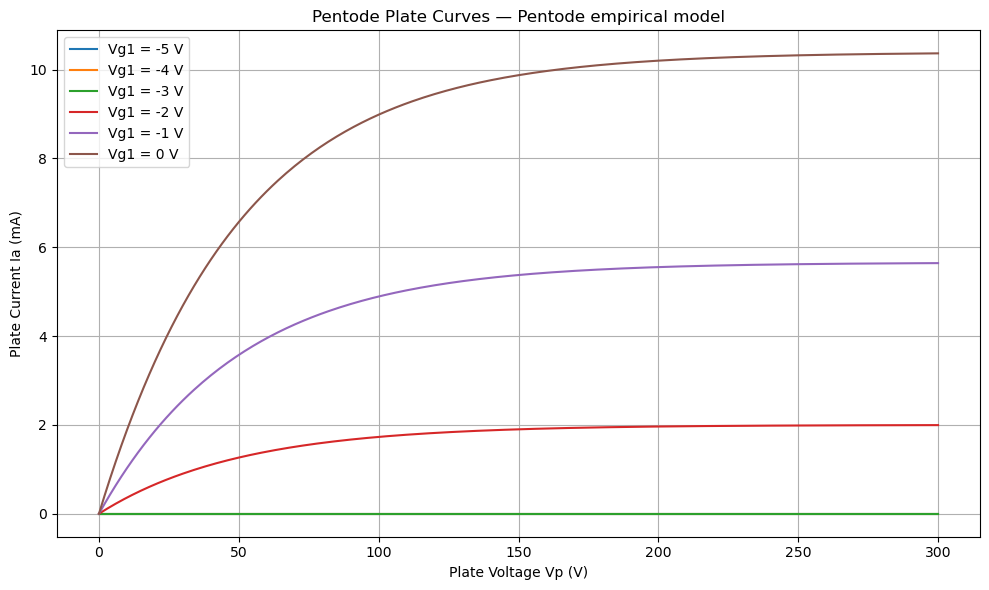

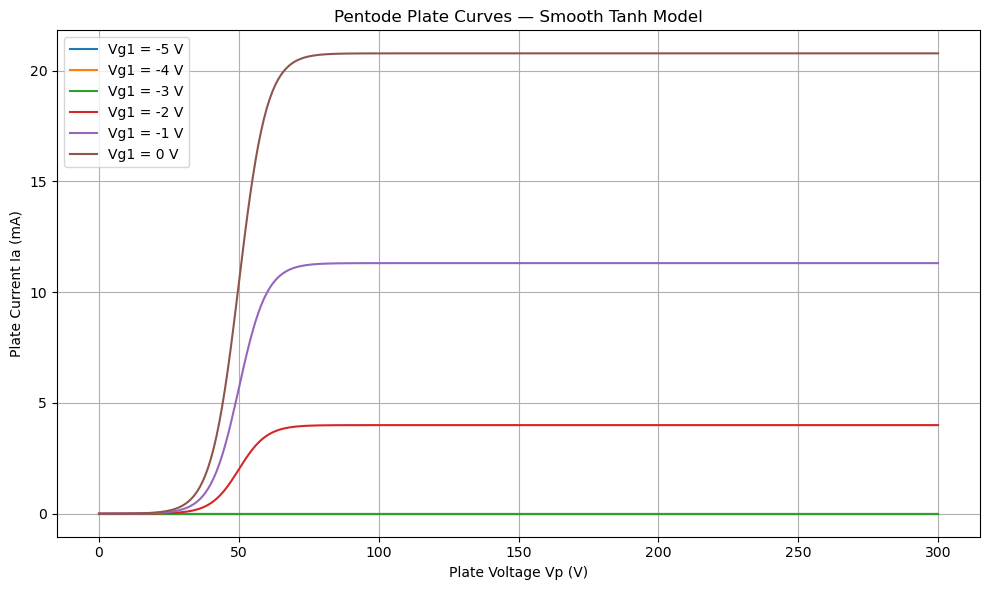

In [9]:
class CustomError(Exception):
    def __init__(self, message="An error occurred", detail=None):
        super().__init__(message)
        self.detail = detail

    def __str__(self):
         return f"{super().__str__()} (Details: {self.detail})" if self.detail else super().__str__()

class Pentode:
    def __init__(self, Vp, Vg_list, Vg2, I0, Vg2_0, Vcut, alpha, beta, Vsat = None, Vknee = None, Vslope = None):
        self.Ip = []
        for Vg1 in Vg_list:
            if Vsat and not (Vknee and Vslope):
                # Pentode empirical model
                Vg1_eff = np.maximum(Vg1 - Vcut, 0)
                term1 = (Vg2 / Vg2_0) ** alpha
                term2 = Vg1_eff ** beta
                term3 = 1 - np.exp(-Vp / Vsat)
                self.Ip.append(I0 * term1 * term2 * term3)
            elif (Vknee and Vslope) and not Vsat:
                # Smoothed pentode model with tanh knee transition
                Vg1_eff = np.maximum(Vg1 - Vcut, 0)
                I_sat = I0 * (Vg2 / Vg2_0)**alpha * Vg1_eff**beta
                transition = 1 - np.tanh((Vknee - Vp) / Vslope)
                self.Ip.append(I_sat * transition)
            else:
                optionals = {"Vsat": Vsat, "Vknee": Vknee, "Vslope": Vslope}
                [print(key) for key, value in optionals.items() if value is None]
                raise CustomError("Missing values", detail="Missing either " + str([key for key, value in optionals.items() if value is None]))
                
Vg2=150
I0=2.0
Vg2_0=150
Vcut=-3.0
alpha=1.0
beta=1.5
Vsat=50

# Voltage Sweep
Vp = np.linspace(0, 300, 301)
Vg1_list = [-5, -4, -3, -2, -1, 0]
pentode = Pentode(Vp, Vg1_list, Vg2, I0, Vg2_0, Vcut, alpha, beta, Vsat = Vsat)

# Plotting
plt.figure(figsize=(10, 6))
for Vg1, Ip in zip(Vg1_list, pentode.Ip):
    plt.plot(Vp, Ip, label=f'Vg1 = {Vg1} V')

plt.xlabel('Plate Voltage Vp (V)')
plt.ylabel('Plate Current Ia (mA)')
plt.title('Pentode Plate Curves — Pentode empirical model')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Vknee=50
Vslope=10
pentode = Pentode(Vp, Vg1_list, Vg2, I0, Vg2_0, Vcut, alpha, beta, Vknee = Vknee, Vslope = Vslope)

# Plotting
plt.figure(figsize=(10, 6))
for Vg1, Ip in zip(Vg1_list, pentode.Ip):
    plt.plot(Vp, Ip, label=f'Vg1 = {Vg1} V')

plt.xlabel('Plate Voltage Vp (V)')
plt.ylabel('Plate Current Ia (mA)')
plt.title('Pentode Plate Curves — Smooth Tanh Model')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [4]:
import numpy as np
import pickle
from scipy.optimize import curve_fit

# Step 1: Load the pickle file
with open("plate_curves.pkl", "rb") as f:
    raw_data = pickle.load(f)

# Step 2: Parse the structure into Vp_data, Vg_data, Ia_data
Vp_data = []
Vg_data = []
Ia_data = []

for key, points in raw_data.items():
    if key.startswith("gv"):
        try:
            Vg_val = float(key.replace("gv", ""))
        except ValueError:
            continue  # skip keys that aren't voltage traces
        for Vp, Ia in points:
            Vp_data.append(Vp)
            Vg_data.append(Vg_val)
            Ia_data.append(Ia)

# Step 3: Convert to numpy arrays
Vp_data = np.array(Vp_data)
Vg_data = np.array(Vg_data)
Ia_data = np.array(Ia_data)

print("Done")

Done


In [5]:
from scipy.optimize import curve_fit
Vp = np.linspace(0, 300, 301)

# Vp_data, Vg_data, Ia_data = flattened arrays from digitized curves
def koren_extended_model(coeffs, Vp, Vg):
    mu, kp, kg, kv, gamma = coeffs
    P = (Vp + kp) ** 1.5
    U = mu / (2 * kv) * (Vg + Vp / mu)
    ln_term = np.log1p(np.exp(U))
    return (P / kg) * (ln_term ** gamma)

Vg_list = [0, -0.5, -1, -1.5, -2, -2.5, -3, -3.5, -4, -4.5]
popts = []

for idx, Vg in enumerate(Vg_list):
    popt, _ = curve_fit(koren_extended_model, (Vp_data[idx], Vg_list[idx]), Ia_data[idx],
                        p0=[100, 300, 1060, 1.73, 1.3],  # initial guesses
                        bounds=(0, [200, 1000, 10000, 5, 3]), # reasonable bounds
                        args = (Vp, Vg),
                       )
    popts.append(popt)

ValueError: 'args' is not a supported keyword argument.